In [1]:
from IPython import get_ipython
get_ipython().run_line_magic("reset","-f")

from PyPackageJonas import *

figures_path = "C:/Users/jonas/Git/Analysis-of-Production-flow-systems-with-focus-on-industry/Latex Thesis/figures/"


In [8]:
marker_list = ["x", "v", "o", "P", "D", "s","|"]

In [9]:
# def z_from_x(x, M, k):
#     x_min = x.min()
#     x_max = x.max()
#     z = (x - x_min) * (M - k + 1)/(x_max - x_min)
#     return lambda l : (l - x_min) * (M - k)/(x_max - x_min)

# def knots(k,M):
#     t = [ (i<k) * 0 + (i-k+1)*(i >= k)*(i<=M-1) + (M-1-k+2)*(i>M-1) for i in range(M+1+k)]
#     return np.array(t)

# def Bx(x,k,i,t):
#     if k == 0:
#         if i >= M-1:
#             return t[i] <= x
#         else:
#             return (t[i] <= x) & ( x < t[i+1])
    
#     if t[i+k] == t[i]:
#         c1 = 0
#     else:
#         c1 = Bx(x,k-1,i,t) * (x-t[i])/(t[i+k] - t[i]) 

#     if t[i+k+1] == t[i+1]:
#         c2 = 0
#     else:
#         c2 = Bx(x,k-1,i+1,t) * (t[i+k+1] - x)/(t[i+k+1] - t[i+1])

#     return c1 + c2

In [15]:
rho_list = [0.1, 0.3, 0.4, 0.6, 0.9, 0.99]
rho_list = [ 0.99]
# n_mesh_list = range(1,40,4)

# p = 3


# mesh to evaluate kernel on
x_lin = np.linspace(0,1,501) #; x_lin = (x_lin[1:] + x_lin[:-1]) / 2
y_lin = np.linspace(0,1,501) #; y_lin = (y_lin[1:] + y_lin[:-1]) / 2
xx, yy = np.meshgrid(x_lin, y_lin)


Trapz_weights_2d = np.array([[1] + [2 for i in range(xx.shape[1]-2)] + [1]] + 
                             [[2] + [4 for i in range(xx.shape[1]-2)] + [2] for j in range(xx.shape[0] - 2)] + 
                             [[1] + [2 for i in range(xx.shape[1]-2)] + [1]] )

Trapez_weights_1d_x = np.array([1] + [2 for i in range(xx.shape[0] - 2)] + [1])

Trapez_weights_1d_y = np.array([1] + [2 for i in range(xx.shape[1] - 2)] + [1])

for idx_rho, rho in enumerate(rho_list):
    # if idx_rho < 4:
    #     continue

    I_true = -0.5*np.log(1-rho**2)

    R = np.array([[1,rho],[rho,1]])

    res = np.full(10, np.nan)
    for j in range(res.__len__()):
        print(f"it {j+1}")
        sim = scipy.stats.multivariate_normal.rvs(mean = np.zeros(2), cov = R, size = 400)

        # x, y = sim[:,0], sim[:,1]

        kernels = [gaussian_kde(sim[:,i]) for i in range(2)]

        x = np.array([kernels[0].integrate_box_1d(-np.inf, y_i) for y_i in sim[:,0]])
        y = np.array([kernels[0].integrate_box_1d(-np.inf, y_i) for y_i in sim[:,1]])

        kern_centers = np.vstack([x,y])

        kern_nn = KernelJones2D_nonnegative_version_Jonas(
            kern_centers,
            proper = False,
            h = kern_centers.shape[1]**(-0.2) * kern_centers.var(axis = 1)**0.5 * 0.3
        )

        # evaluate KDE
        print("  evaluating..")
        res_nn = kern_nn(np.array([xx.flatten(), yy.flatten()]))
        print(f"  prob mass : {res_nn.mean()}")
        
        c_new = res_nn.mean()
        z_nn = res_nn.copy() / c_new
        z_nn = np.reshape(z_nn, xx.shape)

        
        c_xy = (z_nn * Trapz_weights_2d).sum() / 4 / np.prod([xx.shape[0] - 1 , xx.shape[1] - 1])
        Hxy = - (z_nn * np.log(z_nn) * Trapz_weights_2d).sum() / 4 / np.prod([xx.shape[0] - 1 , xx.shape[1] - 1])

        
        c_x = (z_nn.mean(axis = 1) * Trapez_weights_1d_x).sum() / 2 / (xx.shape[0]-1)
        Hx = - (z_nn.mean(axis = 1) * np.log(z_nn.mean(axis = 1)) * Trapez_weights_1d_x).sum() / 2 / (xx.shape[0]-1)

        
        c_y = (z_nn.mean(axis = 0) * Trapez_weights_1d_y).sum() / 2 / (xx.shape[1] - 1)
        Hy = - (z_nn.mean(axis = 0) * np.log(z_nn.mean(axis = 0)) * Trapez_weights_1d_y).sum() / 2 / (xx.shape[1] - 1)

        # correct for weights
        Hx = (Hx - np.log(c_x)) / c_x
        Hy = (Hy - np.log(c_y)) / c_y
        Hxy = (Hxy - np.log(c_xy)) / c_xy

        print(f"  {Hx} + {Hy} - {Hxy} = {Hx + Hy - Hxy}")
        res[j] = Hx + Hy - Hxy

    print(f"rho {rho} results")
    print(f"  {res.mean()}")
    print(f"  {res.var()}")

    

    # res_list = np.full(n_mesh_list.__len__(), np.nan)

    # for idx, n_mesh in tqdm(enumerate(n_mesh_list)):

    #     x, y = sim[:,0], sim[:,1]

    #     M = n_mesh - 1
    #     t = knots(p,M)

    #     # px
    #     z_transformer_x = z_from_x(x,M,p)
    #     px_kernel = np.vstack([Bx(z_transformer_x(x),p,i,t) for i in range(-1,M)])
    #     px = px_kernel.mean(axis = 1)
    #     px_nonnull = px[px > 0]

    #     # Py
    #     z_transformer_y = z_from_x(y,M,p)
    #     py_kernel = np.vstack([Bx(z_transformer_y(y),p,i,t) for i in range(-1,M)])
    #     py = py_kernel.mean(axis = 1)
    #     py_nonnull = py[py > 0]


    #     # Pxy
    #     # pxy_kernel = py_kernel[:,None,:] * px_kernel[None,:,:]
    #     # pxy = (pxy_kernel).mean(axis = 2)
    #     pxy = py_kernel @ px_kernel.T / py_kernel.shape[1]
    #     pxy_nonnull = pxy[pxy > 0]

        
    #     # print(f"xy: {(pxy_nonnull * np.log(pxy_nonnull)).sum()}")
    #     # print( (pxy_nonnull * np.log(pxy_nonnull)).sum() - (px_nonnull*np.log(px_nonnull)).sum() - (py_nonnull * np.log(py_nonnull)).sum() )

    #     res_list[idx] = (pxy_nonnull * np.log(pxy_nonnull)).sum() - (px_nonnull*np.log(px_nonnull)).sum() - (py_nonnull * np.log(py_nonnull)).sum()

    #     # hist = np.histogram2d(sim[:,0], sim[:,1], bins = (n_mesh,n_mesh), density=False)

    #     # densities = hist[0] / sim.shape[0] + 1e-100
    #     # Deltas = np.diff(hist[1]) * np.diff(hist[2])[:,None]
    #     # f0 = densities.sum(axis = 0)
    #     # f1 = densities.sum(axis = 1)
    #     # d0 = np.diff(hist[1])
    #     # d1 = np.diff(hist[2])

    #     # # Using entropy to calculate MI
    #     # res = (densities * np.nan_to_num(np.log(densities / Deltas))).sum() - (f0*np.log(f0 / d0)).sum() - (f1*np.log(f1/d1) ).sum()
    #     # res_list[idx] = res


    # plt.plot(n_mesh_list,res_list - I_true, label=r"$\rho$" + f" = {rho}", marker = marker_list[idx_rho], color="black", linewidth = 0.9)
    # plt.axhline(y = -0.5*np.log(1-rho**2), color = "r")

# plt.xlabel("N")
# # plt.ylabel(r"$I_{estim}\, /\, I_{exact}$")
# plt.ylabel(r"$I_{estim}\, -\, I_{exact}$")
# plt.legend();
# plt.tight_layout()

it 1
Computing normalization constants...  evaluating..
  prob mass : 1.009825803997224
  -0.004932151176989424 + -0.006124303355376458 - -1.6182742630481766 = 1.6072178085158106
it 2
Computing normalization constants...  evaluating..
  prob mass : 1.014303114752348
  -0.009397186911855909 + -0.007594446606145116 - -1.6226663204794234 = 1.6056746869614225
it 3
Computing normalization constants...  evaluating..
  prob mass : 1.0231554862642724
  -0.006220155334648412 + -0.014221860769986713 - -1.6007924973353727 = 1.5803504812307376
it 4
Computing normalization constants...  evaluating..
  prob mass : 1.0164571834980065
  -0.004246535750834486 + -0.018029387326678966 - -1.5738255339424576 = 1.5515496108649443
it 5
Computing normalization constants...  evaluating..
  prob mass : 1.0104744788112396
  -0.004152403023740322 + -0.004438604096678398 - -1.6194435110495402 = 1.6108525039291215
it 6
Computing normalization constants...  evaluating..
  prob mass : 1.0097523240890962
  -0.00465250

In [16]:
rho = 0.99
R = np.array([[1,rho],[rho,1]])
sim = scipy.stats.multivariate_normal.rvs(mean = np.zeros(2), cov = R, size = 400)


kernels = [gaussian_kde(sim[:,i]) for i in range(2)]

x = np.array([kernels[0].integrate_box_1d(-np.inf, y_i) for y_i in sim[:,0]])
y = np.array([kernels[0].integrate_box_1d(-np.inf, y_i) for y_i in sim[:,1]])

kern_centers = np.vstack([x,y])

print( kern_centers.shape[1]**(-1/5) * kern_centers.var()**0.5)

kern_nn = KernelJones2D_nonnegative_version_Jonas(
    kern_centers,
    proper = False,
    h = kern_centers.shape[1]**(-0.2) * kern_centers.var(axis = 1)**0.5 * 0.3
)

# evaluate KDE
print("  evaluating..")
res_nn = kern_nn(np.array([xx.flatten(), yy.flatten()]))
print(f"  prob mass : {res_nn.mean()}")

c_new = res_nn.mean()
z_nn = res_nn.copy() / c_new
z_nn = np.reshape(z_nn, xx.shape)


c_xy = (z_nn * Trapz_weights_2d).sum() / 4 / np.prod([xx.shape[0] - 1 , xx.shape[1] - 1])
Hxy = - (z_nn * np.log(z_nn) * Trapz_weights_2d).sum() / 4 / np.prod([xx.shape[0] - 1 , xx.shape[1] - 1])


c_x = (z_nn.mean(axis = 1) * Trapez_weights_1d_x).sum() / 2 / (xx.shape[0]-1)
Hx = - (z_nn.mean(axis = 1) * np.log(z_nn.mean(axis = 1)) * Trapez_weights_1d_x).sum() / 2 / (xx.shape[0]-1)


c_y = (z_nn.mean(axis = 0) * Trapez_weights_1d_y).sum() / 2 / (xx.shape[1] - 1)
Hy = - (z_nn.mean(axis = 0) * np.log(z_nn.mean(axis = 0)) * Trapez_weights_1d_y).sum() / 2 / (xx.shape[1] - 1)

# correct for weights
Hx = (Hx - np.log(c_x)) / c_x
Hy = (Hy - np.log(c_y)) / c_y
Hxy = (Hxy - np.log(c_xy)) / c_xy

print(f"  {Hx} + {Hy} - {Hxy} = {Hx + Hy - Hxy}")

0.08554933741523826
Computing normalization constants...  evaluating..
  prob mass : 1.013035785807755
  -0.008688895121493085 + -0.007225650727283287 - -1.6509224143737304 = 1.635007868524954


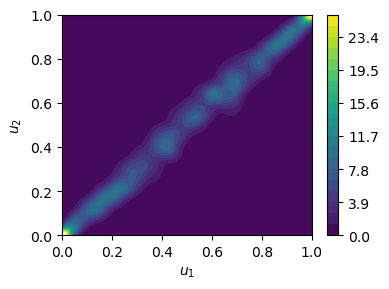

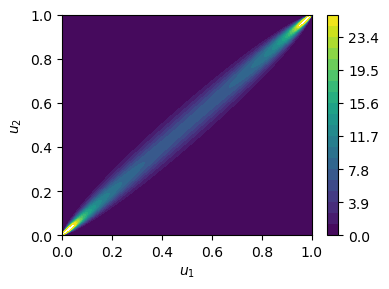

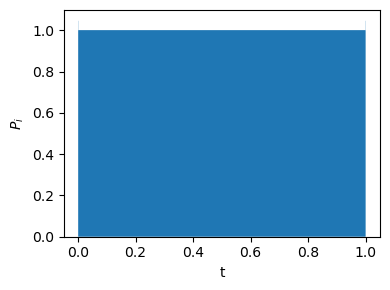

In [19]:


gaus_copula = gen_gaus_c(rho)
xx_c, yy_c = np.meshgrid(np.linspace(0+6e-4,1-6e-4,1500), np.linspace(0+0+6e-4,1-6e-4,1500))
z_c = gaus_copula(xx_c,yy_c)


levels_u = np.min([z_nn.max(), z_c.max(), 24])
levels_u = ((levels_u // 2) // 1 + 1 ) * 2
levels = np.linspace(0, levels_u, 21 )

fig, ax = plt.subplots(1,1, figsize = (4,3))
a = ax.contourf(xx, yy, z_nn, levels=levels)
cbar = plt.colorbar(a)
# ax.set_title("empirical copula")
ax.set_xlabel(r"$u_1$")
ax.set_ylabel(r"$u_2$")
fig.tight_layout()

# plt.savefig(figures_path + "MI estimation/regularized Jones - rho 0.99 - comparison of methods - 0.3 hscott.pdf", bbox_inches='tight')
# plt.savefig(figures_path + "MI estimation/regularized Jones - rho 0.99 - comparison of methods - 0.3 hscott.png", bbox_inches='tight')






fig, ax = plt.subplots(1,1, figsize = (4,3))
a = ax.contourf(xx_c, yy_c, z_c, levels=levels)
plt.colorbar(a)
plt.xlim([0,1])
plt.ylim([0,1]);
ax.set_xlabel(r"$u_1$")
ax.set_ylabel(r"$u_2$")
fig.tight_layout()
# ax.set_title("theoretical copula");

# plt.savefig(figures_path + "MI estimation/theoretical gaussian copula - rho 0.99 - comparison of methods - 0.3 hscott.pdf", bbox_inches='tight')
# plt.savefig(figures_path + "MI estimation/theoretical gaussian copula - rho 0.99 - comparison of methods - 0.3 hscott.png", bbox_inches='tight')



res = z_c.mean(axis = 0)
res = (res[1:] + res[:-1]) / 2
fig,ax = plt.subplots(1,1, figsize = (4,3))
ax.stairs(res, np.linspace(0,1,res.__len__() + 1), fill=True)
# ax.vlines(np.linspace(0,1,res.__len__()+1), 0, res.max(), colors='w')
ax.set_xlabel("t")
ax.set_ylabel(r"$P_i$")
# ax.set_xticks(np.linspace(1,n_bins, n_bins) / n_bins - 1 / (2 * n_bins))
# ax.set_xticklabels([i+1 for i in range(n_bins)])
fig.tight_layout()


# for small rho, much closer to uniform marginals than large rho. Might want to non-netivize and re-normalize each kernel

# other

In [6]:
rho = 0.99
data = scipy.stats.multivariate_normal.rvs(mean = None, cov = np.array([[1,rho],[rho,1]]), size = 300)

data.var(axis = 0)

array([1.05045568, 1.03697759])

In [35]:
X = data[:,0]
Y = data[:,1]


X = scipy.stats.ecdf(X).cdf.evaluate(X) - 1 / 2 / X.__len__()       # Correct such that equally dist at top and buttom
Y = scipy.stats.ecdf(Y).cdf.evaluate(Y) - 1 / 2 / X.__len__()

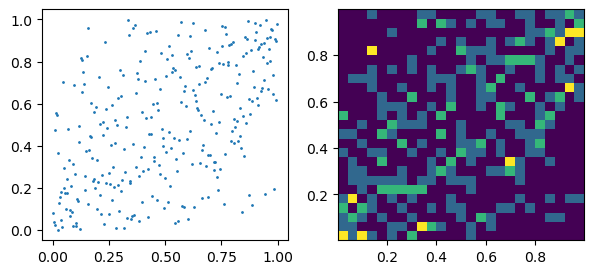

In [36]:
fig, ax = plt.subplots(1,2, figsize = (7,3))
ax[0].scatter(X,Y, s = 1)
ax[1].hist2d(X,Y, 25);

In [37]:
kern_centers = np.vstack([X,Y])

In [38]:
# h = np.hstack([kde(kern_centers[i,:], MIN = 0, MAX = 1)[0] for i in range(2)])
h = kern_centers.shape[1]**(-1/5) * kern_centers.var(axis = 1)**0.5
print(h)

[0.09225347 0.09225347]


In [39]:
# Generate kernel (takes some time to compute normalization constant -> checked later that sum is approx 1)
# kern_nn = KernelJones2D_nonnegative(np.vstack([X,Y]))
kern_nn = KernelJones2D_nonnegative_version_Jonas(
    kern_centers,
    h
)

Computing normalization constants...

In [40]:
# Generate mesh to evaluate on
x_lin = np.linspace(0,1,701) #; x_lin = (x_lin[1:] + x_lin[:-1]) / 2
y_lin = np.linspace(0,1,701) #; y_lin = (y_lin[1:] + y_lin[:-1]) / 2
xx, yy = np.meshgrid(x_lin, y_lin)

In [41]:
res_nn = kern_nn(np.array([xx.flatten(), yy.flatten()]))
print(f"prob mass : {res_nn.mean()}")

prob mass : 1.0168680578595126


In [42]:
c_new = res_nn.mean()

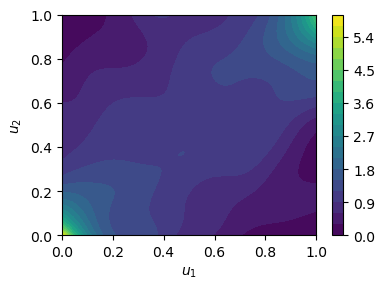

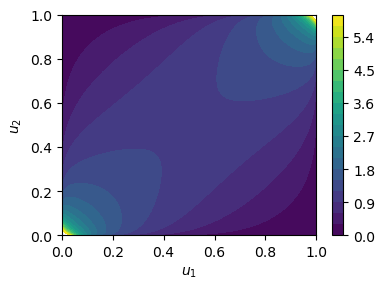

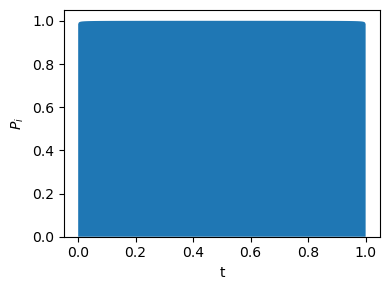

In [43]:
z_nn = res_nn.copy() / c_new
z_nn = np.reshape(z_nn, xx.shape)

gaus_copula = gen_gaus_c(rho)
xx_c, yy_c = np.meshgrid(np.linspace(0+6e-4,1-6e-4,1500), np.linspace(0+0+6e-4,1-6e-4,1500))
z_c = gaus_copula(xx_c,yy_c)


levels_u = np.min([z_nn.max(), z_c.max(), 24])
levels_u = ((levels_u // 2) // 1 + 1 ) * 2
levels = np.linspace(0, levels_u, 21 )

fig, ax = plt.subplots(1,1, figsize = (4,3))
a = ax.contourf(xx, yy, z_nn, levels=levels)
cbar = plt.colorbar(a)
# ax.set_title("empirical copula")
ax.set_xlabel(r"$u_1$")
ax.set_ylabel(r"$u_2$")
fig.tight_layout()

# plt.savefig(figures_path + "MI estimation/regularized Jones - rho 0.5.pdf", bbox_inches='tight')
# plt.savefig(figures_path + "MI estimation/regularized Jones - rho 0.5.png", bbox_inches='tight')






fig, ax = plt.subplots(1,1, figsize = (4,3))
a = ax.contourf(xx_c, yy_c, z_c, levels=levels)
plt.colorbar(a)
plt.xlim([0,1])
plt.ylim([0,1]);
ax.set_xlabel(r"$u_1$")
ax.set_ylabel(r"$u_2$")
fig.tight_layout()
# ax.set_title("theoretical copula");

# plt.savefig(figures_path + "MI estimation/theoretical gaussian copula - rho 0.9.pdf", bbox_inches='tight')
# plt.savefig(figures_path + "MI estimation/theoretical gaussian copula - rho 0.9.png", bbox_inches='tight')



res = z_c.mean(axis = 0)
res = (res[1:] + res[:-1]) / 2
fig,ax = plt.subplots(1,1, figsize = (4,3))
ax.stairs(res, np.linspace(0,1,res.__len__() + 1), fill=True)
# ax.vlines(np.linspace(0,1,res.__len__()+1), 0, res.max(), colors='w')
ax.set_xlabel("t")
ax.set_ylabel(r"$P_i$")
# ax.set_xticks(np.linspace(1,n_bins, n_bins) / n_bins - 1 / (2 * n_bins))
# ax.set_xticklabels([i+1 for i in range(n_bins)])
fig.tight_layout()


# for small rho, much closer to uniform marginals than large rho. Might want to non-netivize and re-normalize each kernel

In [44]:
# raw
# Hxy = - (z_nn  * np.log(z_nn)).mean()
# Hx  = - (z_nn.mean(axis = 0) * np.log(z_nn.mean(axis = 0))).mean()
# Hy  = - (z_nn.mean(axis = 1) * np.log(z_nn.mean(axis = 1))).mean()
# print(f"{Hx} + {Hy} - {Hxy} = {Hx + Hy - Hxy}")



# Trapez est.
Trapz_weights_2d = np.array([[1] + [2 for i in range(z_nn.shape[1]-2)] + [1]] + 
                             [[2] + [4 for i in range(z_nn.shape[1]-2)] + [2] for j in range(z_nn.shape[0] - 2)] + 
                             [[1] + [2 for i in range(z_nn.shape[1]-2)] + [1]] )
c_xy = (z_nn * Trapz_weights_2d).sum() / 4 / np.prod([z_nn.shape[0] - 1 , z_nn.shape[1] - 1])
Hxy = - (z_nn * np.log(z_nn) * Trapz_weights_2d).sum() / 4 / np.prod([z_nn.shape[0] - 1 , z_nn.shape[1] - 1])

Trapez_weights_1d = np.array([1] + [2 for i in range(z_nn.shape[0] - 2)] + [1])
c_x = (z_nn.mean(axis = 1) * Trapez_weights_1d).sum() / 2 / (z_nn.shape[0]-1)
Hx = - (z_nn.mean(axis = 1) * np.log(z_nn.mean(axis = 1)) * Trapez_weights_1d).sum() / 2 / (z_nn.shape[0]-1)

Trapez_weights_1d = np.array([1] + [2 for i in range(z_nn.shape[1] - 2)] + [1])
c_y = (z_nn.mean(axis = 0) * Trapez_weights_1d).sum() / 2 / (z_nn.shape[1] - 1)
Hy = - (z_nn.mean(axis = 0) * np.log(z_nn.mean(axis = 0)) * Trapez_weights_1d).sum() / 2 / (z_nn.shape[1] - 1)

# correct for weights
Hx = (Hx - np.log(c_x)) / c_x
Hy = (Hy - np.log(c_y)) / c_y
Hxy = (Hxy - np.log(c_xy)) / c_xy

print(f"{Hx} + {Hy} - {Hxy} = {Hx + Hy - Hxy}")




# Simpson set.
Simpsonweights_2d = np.array([[1] + [2* ((i+1)%2) + 2 for i in range(z_nn.shape[1]-2)] + [1]] + 
                             [[2 * ((j+1)%2) + 2] + [(2* ((i+1)%2) + 2) * (2 * ((j+1)%2) + 2) for i in range(z_nn.shape[1]-2)] + [2 * ((j+1)%2) + 2] for j in range(z_nn.shape[0]-2)] + 
                             [[1] + [2* ((i+1)%2) + 2 for i in range(z_nn.shape[1]-2)] + [1]] )
c_xy = (z_nn * Simpsonweights_2d).sum() / 9 / np.prod([z_nn.shape[0] - 1 , z_nn.shape[1] - 1])
Hxy = - (z_nn * np.log(z_nn) * Simpsonweights_2d).sum() / 9 / np.prod([z_nn.shape[0] - 1 , z_nn.shape[1] - 1])

Simpsonweights_1d = np.array([1] + [2* ((i+1)%2) + 2 for i in range(z_nn.shape[0] - 2)] + [1])
c_x = (z_nn.mean(axis = 1) * Simpsonweights_1d).sum() / 3 / (z_nn.shape[0]-1)
Hx = - (z_nn.mean(axis = 1) * np.log(z_nn.mean(axis = 1)) * Simpsonweights_1d).sum() / 3 / (z_nn.shape[0]-1)

Simpsonweights_1d = np.array([1] + [2* ((i+1)%2) + 2 for i in range(z_nn.shape[1] - 2)] + [1])
c_y = (z_nn.mean(axis = 0) * Simpsonweights_1d).sum() / 3 / (z_nn.shape[1] - 1)
Hy = - (z_nn.mean(axis = 0) * np.log(z_nn.mean(axis = 0)) * Simpsonweights_1d).sum() / 3 / (z_nn.shape[1]-1)

# correct for weights
Hx = (Hx - np.log(c_x)) / c_x
Hy = (Hy - np.log(c_y)) / c_y
Hxy = (Hxy - np.log(c_xy)) / c_xy

print(f"{Hx} + {Hy} - {Hxy} = {Hx + Hy - Hxy}")




print(f"theoretical MI : {-0.5 * np.log( 1 - rho**2)}")


# rho = 0.95 - true MI = 1.1639514504891677 - using 700x700 grid - probability mass is not 1 anymore - correcting for extra mass around 21 - 24
# runs:
    # 72.93643097088923
    # 47.373618075280035
    # 58.424153422937415
# increasing the number density of mesh seems to get more accurate results but still not close





# rho = 0.9 - true MI = 0.8303656034108255 - using 500x500 grid
# runs:
    # 0.771305692312177
    # 0.7160725163449495
    # 0.7015484781230266
    # 0.7586075238740865
    # 0.7514862622065581
    # 0.6293326115112262
    # 0.6762494918225319

# rho = 0.9 - true MI = 0.8303656034108255 - using 700x700 grid
# runs:
    # 0.6953513129241953
    # 1.0449855468953293
    # 0.6864321660179645
    # 0.9863725725648258
    # 





# rho = 0.5 - true MI = 0.14384103622589045 - using 700x700grid
# runs using wrong formula :((:
    # 0.16759313090746544
    # 0.13303523637042428
    # 0.15237370288786833
    # 0.1639709402127958
    # 0.21079069407706263
    # 0.1718386132601093
    # 0.228978809221221
# runs using the correct formula :(
    # 0.17701221853502314
    # 0.17947677141701932
    # 0.14395840549990835
    # 0.12253432656735835
    # 0.15624692951574992
    # 0.14836583766741554
    # 0.13452058261687702
    # 0.13787030661529773
    # 0.1562510723508732
    # 0.15381115644310786
    # 0.1717448720720293
# runs using center points instead of edges: (want less than theoretical)
    # 0.154019880485063
    # 0.18973397258966954
    # 0.19830792949351805
    # 0.2071606312323414
    # 0.1690216336754641
    # 0.1262147630773271
    # 0.18244154238367982
    # 0.1284536651794335
    # 0.17385746452999024



-0.00017605077900384564 + -0.00018886321108841004 - -0.11878189843399448 = 0.11841698444390222
-0.00017509657768744068 + -0.00018747318660097289 - -0.11877729244870555 = 0.11841472268441713
theoretical MI : 0.14384103622589045


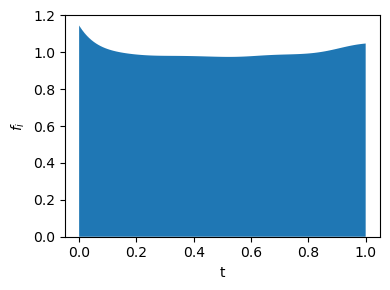

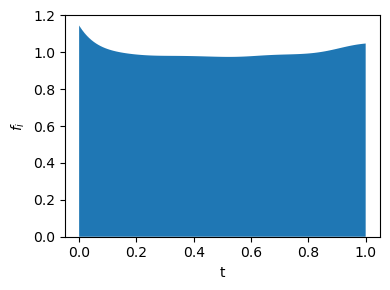

In [45]:
# u_0
marginal_1 = z_nn.mean(axis = 1)
marginal_1_centers = (marginal_1[1:] + marginal_1[:-1]) / 2

fig,ax = plt.subplots(1,1, figsize = (4,3))
ax.stairs(marginal_1_centers, np.linspace(0,1,marginal_1_centers.__len__() + 1), fill=True)
ax.set_xlabel("t")
ax.set_ylabel(r"$f_i$")
fig.tight_layout()

# plt.savefig(figures_path + "MI estimation/Bad MI estimate var 1 - corrected method - k = 1", bbox_inches='tight')



# u_1
marginal_2 = z_nn.mean(axis = 1)
marginal_2_centers = (marginal_2[1:] + marginal_2[:-1]) / 2

fig,ax = plt.subplots(1,1, figsize = (4,3))
ax.stairs(marginal_2_centers, np.linspace(0,1,marginal_2_centers.__len__() + 1), fill=True)
ax.set_xlabel("t")
ax.set_ylabel(r"$f_i$")
fig.tight_layout()

In [46]:
# correction for probability mass
# print(f"{Hx/c_new + Hy/c_new - Hxy/c_new  - 1/c_new * np.log(c_new)}")

In [47]:
# variance of each component is 1/12 (is uniform dist.)

# grund til copula er hvis man senere vil bruge non-parametric network, så skal man bruge copula, så god est. af fordeling er vigtig

# Problem er peaks for høje rho, som med samme h ikke bliver lige godt repræsenteret

In [48]:


# for small rho, much closer to uniform marginals than large rho. Might want to non-negativize and re-normalize each kernel